In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        self.b = conv_block(512, 1024)
        
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        return outputs

In [3]:
model=build_unet()
model

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [4]:
import pandas as pd
train_df=pd.read_csv('/content/drive/MyDrive/Medical Image Segmentation/train.csv')
val_df=pd.read_csv('/content/drive/MyDrive/Medical Image Segmentation/val.csv')

In [5]:
train_df

,id,patient,image_path,mask_path,diagnosis
0,16,TCGA_HT_7855_19951020,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
1,11,TCGA_FG_6688_20020215,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
2,57,TCGA_DU_6407_19860514,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
3,22,TCGA_DU_5855_19951217,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
4,4,TCGA_CS_6668_20011025,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
...,...,...,...,...,...
2944,16,TCGA_DU_6401_19831001,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
2945,18,TCGA_FG_A4MU_20030903,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
2946,35,TCGA_DU_8162_19961029,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
2947,2,TCGA_DU_8164_19970111,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0


In [6]:
import pandas as pd

train_df = train_df[~train_df['image_path'].str.contains('mask')]

train_df.reset_index(drop=True, inplace=True)

train_df


,id,patient,image_path,mask_path,diagnosis
0,16,TCGA_HT_7855_19951020,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
1,11,TCGA_FG_6688_20020215,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
2,57,TCGA_DU_6407_19860514,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
3,22,TCGA_DU_5855_19951217,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
4,4,TCGA_CS_6668_20011025,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
...,...,...,...,...,...
2940,16,TCGA_DU_6401_19831001,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
2941,18,TCGA_FG_A4MU_20030903,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
2942,35,TCGA_DU_8162_19961029,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
2943,2,TCGA_DU_8164_19970111,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0


In [7]:
import pandas as pd

val_df = val_df[~val_df['image_path'].str.contains('mask')]

val_df.reset_index(drop=True, inplace=True)

val_df


,id,patient,image_path,mask_path,diagnosis
0,21,TCGA_HT_8563_19981209,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
1,17,TCGA_EZ_7264_20010816,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
2,6,TCGA_FG_5964_20010511,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
3,47,TCGA_DU_6399_19830416,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
4,19,TCGA_HT_8113_19930809,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
...,...,...,...,...,...
389,45,TCGA_FG_7643_20021104,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
390,5,TCGA_HT_7884_19980913,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
391,60,TCGA_FG_8189_20030516,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
392,24,TCGA_DU_6407_19860514,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
train_transforms = A.Compose([
        A.Resize(224,224, p=1.0),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        ToTensorV2(),
    ])

inference_transforms = A.Compose([
    A.Resize(224,224, p=1.0),
    ToTensorV2(),
])

In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import albumentations as A
import os

dir='/content/drive/MyDrive/Medical Image Segmentation'

class MRISegmentationDataset(Dataset):
    def __init__(self,df,transform=None):
        super(MRISegmentationDataset,self).__init__()
        self.image_path=df['image_path'].to_list()
        self.mask_path=df['mask_path'].to_list()
        self.transform=transform

    def load_transform(self,index):
        image_path=self.image_path[index]
        mask_path=self.mask_path[index]

        image,mask=Image.open(os.path.join(dir,image_path)),Image.open(os.path.join(dir,mask_path))

        image=np.array(image).astype(np.float32)/255
        mask=np.array(mask).astype(np.float32)/255

        return image,mask

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self,index):
        image,mask=self.load_transform(index)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            return transformed['image'], transformed['mask'].unsqueeze_(0)
        else:
            transformed = ToTensorV2()(image=image, mask=mask)
            return transformed['image'], transformed['mask'].unsqueeze_(0)

In [10]:
train_ds=MRISegmentationDataset(train_df,train_transforms)
val_ds=MRISegmentationDataset(val_df,inference_transforms)

In [11]:
from torch.utils.data import DataLoader
train_loader=DataLoader(
    train_ds,batch_size=32,shuffle=True
)

In [12]:
val_loader=DataLoader(
    val_ds,batch_size=8,shuffle=False
)

In [ ]:
import torch
import os
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

# Define training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
checkpoint_path = '/content/drive/MyDrive/Medical Image Segmentation/checkpoint.pth'
best_eval_dice = float('-inf')

start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    val_accuracy_best = checkpoint['eval_dice']
    start_epoch = checkpoint['epoch']
    print("Model checkpoint loaded. Best validation accuracy:", val_accuracy_best)

# Model, optimizer, scheduler, loss_fn, train_loader, val_loader initialization here...

model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=8, factor=0.1, verbose=True
)

for epoch in tqdm(range(start_epoch, start_epoch + epochs), desc="Epoch"):
    print(f'\nEpoch {epoch + 1}/{start_epoch + epochs}')
    model.train()

    train_loss, train_dice = 0, 0

    for batch, (X, y) in enumerate(tqdm(train_loader, desc="Training Iteration")):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        predicted_class = torch.sigmoid(y_pred)
        predicted_class = (predicted_class > 0.5).float()

        eps = 1e-8
        train_dice += (
                (2 * (y * predicted_class).sum() + eps) / ((y + predicted_class).sum() + eps)
        ).cpu().item()

    train_loss = train_loss / len(train_loader)
    train_dice = train_dice / len(train_loader)

    model.eval()

    eval_loss, eval_dice = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y)
            eval_loss += loss.item()

            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.5).float()

            eps = 1e-8
            eval_dice += (
                    (2 * (y * predicted_class).sum() + eps) / ((y + predicted_class).sum() + eps)
            ).cpu().item()

        eval_loss = eval_loss / len(val_loader)
        eval_dice = eval_dice / len(val_loader)

    if eval_dice > best_eval_dice:
        torch.save({'model_state_dict': model.state_dict(),
                    'eval_dice': eval_dice,
                    'epoch': epoch},
                   checkpoint_path)
        best_eval_dice = eval_dice
        print("Model saved as it achieved better evaluation dice score.")

    current_lr = 0
    if scheduler:
        scheduler.step(eval_loss)
        current_lr = optimizer.param_groups[0]['lr']

    log_text = f'loss: {train_loss:.4f} - dice_score: {train_dice:.4f} - eval_loss: {eval_loss:.4f} - eval_dice_score: {eval_dice:.4f}'

    if scheduler:
        print(log_text + f' - lr: {current_lr}')
    else:
        print(log_text)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100



Epoch:   1%|          | 1/100 [45:34<75:12:32, 2734.88s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.4228 - dice_score: 0.3357 - eval_loss: 0.4229 - eval_dice_score: 0.2357 - lr: 0.0001

Epoch 2/100



Epoch:   2%|▏         | 2/100 [48:10<33:09:06, 1217.83s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.2995 - dice_score: 0.4204 - eval_loss: 0.2910 - eval_dice_score: 0.2813 - lr: 0.0001

Epoch 3/100



Epoch:   3%|▎         | 3/100 [50:45<19:44:07, 732.45s/it] 

Model saved as it achieved better evaluation dice score.
loss: 0.2578 - dice_score: 0.4399 - eval_loss: 0.2511 - eval_dice_score: 0.4170 - lr: 0.0001

Epoch 4/100



Epoch:   4%|▍         | 4/100 [53:20<13:26:55, 504.33s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.2216 - dice_score: 0.5530 - eval_loss: 0.3780 - eval_dice_score: 0.4841 - lr: 0.0001

Epoch 5/100



Epoch:   5%|▌         | 5/100 [55:54<9:58:38, 378.08s/it] 

loss: 0.1959 - dice_score: 0.5808 - eval_loss: 0.1931 - eval_dice_score: 0.1905 - lr: 0.0001

Epoch 6/100



Epoch:   6%|▌         | 6/100 [58:28<7:53:07, 302.00s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.1714 - dice_score: 0.5615 - eval_loss: 0.1639 - eval_dice_score: 0.5754 - lr: 0.0001

Epoch 7/100



Epoch:   7%|▋         | 7/100 [1:01:02<6:33:12, 253.68s/it]

loss: 0.1493 - dice_score: 0.6098 - eval_loss: 0.1420 - eval_dice_score: 0.1826 - lr: 0.0001

Epoch 8/100



Epoch:   8%|▊         | 8/100 [1:03:37<5:40:30, 222.07s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.1313 - dice_score: 0.6478 - eval_loss: 0.1286 - eval_dice_score: 0.6415 - lr: 0.0001

Epoch 9/100



Epoch:   9%|▉         | 9/100 [1:06:11<5:04:37, 200.85s/it]

loss: 0.1155 - dice_score: 0.6781 - eval_loss: 0.1127 - eval_dice_score: 0.4516 - lr: 0.0001

Epoch 10/100



Epoch:  10%|█         | 10/100 [1:08:45<4:39:31, 186.35s/it]

loss: 0.1031 - dice_score: 0.6838 - eval_loss: 0.1040 - eval_dice_score: 0.6283 - lr: 0.0001

Epoch 11/100



Epoch:  11%|█         | 11/100 [1:11:19<4:21:45, 176.47s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0916 - dice_score: 0.7144 - eval_loss: 0.0932 - eval_dice_score: 0.6524 - lr: 0.0001

Epoch 12/100



Epoch:  12%|█▏        | 12/100 [1:13:54<4:09:07, 169.86s/it]

loss: 0.0825 - dice_score: 0.7136 - eval_loss: 0.0861 - eval_dice_score: 0.4685 - lr: 0.0001

Epoch 13/100



Epoch:  13%|█▎        | 13/100 [1:16:28<3:59:33, 165.22s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0745 - dice_score: 0.7327 - eval_loss: 0.0719 - eval_dice_score: 0.7306 - lr: 0.0001

Epoch 14/100



Epoch:  14%|█▍        | 14/100 [1:19:03<3:52:10, 161.98s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0669 - dice_score: 0.7481 - eval_loss: 0.0645 - eval_dice_score: 0.7625 - lr: 0.0001

Epoch 15/100



Epoch:  15%|█▌        | 15/100 [1:21:38<3:46:33, 159.92s/it]

loss: 0.0606 - dice_score: 0.7545 - eval_loss: 0.0736 - eval_dice_score: 0.2874 - lr: 0.0001

Epoch 16/100



Epoch:  16%|█▌        | 16/100 [1:24:12<3:41:29, 158.21s/it]

loss: 0.0560 - dice_score: 0.7497 - eval_loss: 0.0554 - eval_dice_score: 0.6932 - lr: 0.0001

Epoch 17/100



Epoch:  17%|█▋        | 17/100 [1:26:46<3:37:12, 157.02s/it]

loss: 0.0510 - dice_score: 0.7587 - eval_loss: 0.0508 - eval_dice_score: 0.7515 - lr: 0.0001

Epoch 18/100



Epoch:  18%|█▊        | 18/100 [1:29:21<3:33:46, 156.42s/it]

loss: 0.0457 - dice_score: 0.7796 - eval_loss: 0.0462 - eval_dice_score: 0.7437 - lr: 0.0001

Epoch 19/100



Epoch:  19%|█▉        | 19/100 [1:31:57<3:30:50, 156.18s/it]

loss: 0.0418 - dice_score: 0.7774 - eval_loss: 0.0414 - eval_dice_score: 0.7585 - lr: 0.0001

Epoch 20/100



Epoch:  20%|██        | 20/100 [1:34:32<3:27:40, 155.75s/it]

loss: 0.0396 - dice_score: 0.7585 - eval_loss: 0.0407 - eval_dice_score: 0.6989 - lr: 0.0001

Epoch 21/100



Epoch:  21%|██        | 21/100 [1:37:07<3:24:52, 155.60s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0350 - dice_score: 0.7955 - eval_loss: 0.0358 - eval_dice_score: 0.7626 - lr: 0.0001

Epoch 22/100



Epoch:  22%|██▏       | 22/100 [1:39:43<3:22:23, 155.68s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0326 - dice_score: 0.8000 - eval_loss: 0.0340 - eval_dice_score: 0.8095 - lr: 0.0001

Epoch 23/100



Epoch:  23%|██▎       | 23/100 [1:42:18<3:19:29, 155.44s/it]

loss: 0.0309 - dice_score: 0.8013 - eval_loss: 0.0300 - eval_dice_score: 0.7600 - lr: 0.0001

Epoch 24/100



Epoch:  24%|██▍       | 24/100 [1:44:53<3:16:44, 155.32s/it]

loss: 0.0290 - dice_score: 0.7959 - eval_loss: 0.0281 - eval_dice_score: 0.7299 - lr: 0.0001

Epoch 25/100



Epoch:  25%|██▌       | 25/100 [1:47:28<3:14:00, 155.21s/it]

loss: 0.0263 - dice_score: 0.8035 - eval_loss: 0.0272 - eval_dice_score: 0.7548 - lr: 0.0001

Epoch 26/100



Epoch:  26%|██▌       | 26/100 [1:50:02<3:11:11, 155.02s/it]

loss: 0.0240 - dice_score: 0.8237 - eval_loss: 0.0252 - eval_dice_score: 0.8050 - lr: 0.0001

Epoch 27/100



Epoch:  27%|██▋       | 27/100 [1:52:38<3:08:38, 155.05s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0226 - dice_score: 0.8337 - eval_loss: 0.0224 - eval_dice_score: 0.8367 - lr: 0.0001

Epoch 28/100



Epoch:  28%|██▊       | 28/100 [1:55:12<3:05:55, 154.93s/it]

loss: 0.0209 - dice_score: 0.8460 - eval_loss: 0.0269 - eval_dice_score: 0.7441 - lr: 0.0001

Epoch 29/100



Epoch:  29%|██▉       | 29/100 [1:57:46<3:03:05, 154.72s/it]

loss: 0.0200 - dice_score: 0.8348 - eval_loss: 0.0199 - eval_dice_score: 0.8247 - lr: 0.0001

Epoch 30/100



Epoch:  30%|███       | 30/100 [2:00:22<3:00:41, 154.88s/it]

loss: 0.0190 - dice_score: 0.8419 - eval_loss: 0.0208 - eval_dice_score: 0.7545 - lr: 0.0001

Epoch 31/100



Epoch:  31%|███       | 31/100 [2:02:57<2:58:07, 154.89s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0176 - dice_score: 0.8518 - eval_loss: 0.0178 - eval_dice_score: 0.8509 - lr: 0.0001

Epoch 32/100



Epoch:  32%|███▏      | 32/100 [2:05:31<2:55:26, 154.80s/it]

loss: 0.0169 - dice_score: 0.8549 - eval_loss: 0.0197 - eval_dice_score: 0.7403 - lr: 0.0001

Epoch 33/100



Epoch:  33%|███▎      | 33/100 [2:08:05<2:52:40, 154.63s/it]

loss: 0.0162 - dice_score: 0.8479 - eval_loss: 0.0176 - eval_dice_score: 0.7715 - lr: 0.0001

Epoch 34/100



Epoch:  34%|███▍      | 34/100 [2:10:40<2:50:12, 154.74s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0152 - dice_score: 0.8592 - eval_loss: 0.0153 - eval_dice_score: 0.8559 - lr: 0.0001

Epoch 35/100



Epoch:  35%|███▌      | 35/100 [2:13:13<2:47:03, 154.21s/it]

loss: 0.0147 - dice_score: 0.8502 - eval_loss: 0.0165 - eval_dice_score: 0.7580 - lr: 0.0001

Epoch 36/100



Epoch:  36%|███▌      | 36/100 [2:15:46<2:43:56, 153.70s/it]

loss: 0.0134 - dice_score: 0.8710 - eval_loss: 0.0144 - eval_dice_score: 0.7797 - lr: 0.0001

Epoch 37/100



Epoch:  37%|███▋      | 37/100 [2:18:19<2:41:09, 153.48s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0133 - dice_score: 0.8618 - eval_loss: 0.0143 - eval_dice_score: 0.8597 - lr: 0.0001

Epoch 38/100



Epoch:  38%|███▊      | 38/100 [2:20:52<2:38:20, 153.24s/it]

loss: 0.0128 - dice_score: 0.8676 - eval_loss: 0.0127 - eval_dice_score: 0.8510 - lr: 0.0001

Epoch 39/100



Epoch:  39%|███▉      | 39/100 [2:23:24<2:35:34, 153.03s/it]

loss: 0.0124 - dice_score: 0.8663 - eval_loss: 0.0126 - eval_dice_score: 0.8228 - lr: 0.0001

Epoch 40/100



Epoch:  40%|████      | 40/100 [2:25:58<2:33:16, 153.27s/it]

loss: 0.0117 - dice_score: 0.8690 - eval_loss: 0.0160 - eval_dice_score: 0.6863 - lr: 0.0001

Epoch 41/100



Epoch:  41%|████      | 41/100 [2:28:31<2:30:40, 153.22s/it]

loss: 0.0126 - dice_score: 0.8498 - eval_loss: 0.0127 - eval_dice_score: 0.8469 - lr: 0.0001

Epoch 42/100



Epoch:  42%|████▏     | 42/100 [2:31:03<2:27:52, 152.97s/it]

loss: 0.0110 - dice_score: 0.8743 - eval_loss: 0.0117 - eval_dice_score: 0.8590 - lr: 0.0001

Epoch 43/100



Epoch:  43%|████▎     | 43/100 [2:33:36<2:25:12, 152.85s/it]

loss: 0.0106 - dice_score: 0.8725 - eval_loss: 0.0131 - eval_dice_score: 0.7910 - lr: 0.0001

Epoch 44/100



Epoch:  44%|████▍     | 44/100 [2:36:08<2:22:25, 152.59s/it]

loss: 0.0108 - dice_score: 0.8607 - eval_loss: 0.0137 - eval_dice_score: 0.7673 - lr: 0.0001

Epoch 45/100



Epoch:  45%|████▌     | 45/100 [2:38:40<2:19:50, 152.55s/it]

loss: 0.0113 - dice_score: 0.8576 - eval_loss: 0.0115 - eval_dice_score: 0.8475 - lr: 0.0001

Epoch 46/100



Epoch:  46%|████▌     | 46/100 [2:41:13<2:17:22, 152.64s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0101 - dice_score: 0.8711 - eval_loss: 0.0102 - eval_dice_score: 0.8683 - lr: 0.0001

Epoch 47/100



Epoch:  47%|████▋     | 47/100 [2:43:46<2:14:48, 152.61s/it]

loss: 0.0100 - dice_score: 0.8720 - eval_loss: 0.0104 - eval_dice_score: 0.8650 - lr: 0.0001

Epoch 48/100



Epoch:  48%|████▊     | 48/100 [2:46:19<2:12:25, 152.80s/it]

Model saved as it achieved better evaluation dice score.
loss: 0.0096 - dice_score: 0.8757 - eval_loss: 0.0094 - eval_dice_score: 0.8763 - lr: 0.0001

Epoch 49/100



Epoch:  49%|████▉     | 49/100 [2:48:52<2:09:48, 152.71s/it]

loss: 0.0088 - dice_score: 0.8726 - eval_loss: 0.0096 - eval_dice_score: 0.8685 - lr: 0.0001

Epoch 50/100



Epoch:  50%|█████     | 50/100 [2:51:24<2:07:07, 152.55s/it]

loss: 0.0091 - dice_score: 0.8754 - eval_loss: 0.0113 - eval_dice_score: 0.8232 - lr: 0.0001

Epoch 51/100



Epoch:  51%|█████     | 51/100 [2:53:56<2:04:28, 152.42s/it]

loss: 0.0093 - dice_score: 0.8679 - eval_loss: 0.0103 - eval_dice_score: 0.8543 - lr: 0.0001

Epoch 52/100



Epoch:  52%|█████▏    | 52/100 [2:56:28<2:01:58, 152.47s/it]

loss: 0.0083 - dice_score: 0.8826 - eval_loss: 0.0095 - eval_dice_score: 0.8513 - lr: 0.0001

Epoch 53/100



Epoch:  53%|█████▎    | 53/100 [2:59:01<1:59:24, 152.43s/it]

loss: 0.0084 - dice_score: 0.8778 - eval_loss: 0.0137 - eval_dice_score: 0.6906 - lr: 0.0001

Epoch 54/100



Epoch:  54%|█████▍    | 54/100 [3:01:33<1:56:51, 152.42s/it]

loss: 0.0138 - dice_score: 0.7718 - eval_loss: 0.0113 - eval_dice_score: 0.8117 - lr: 0.0001

Epoch 55/100



Training Iteration:  96%|█████████▌| 89/93 [02:18<00:06,  1.54s/it]

TESTING AND INFERENCE

In [13]:
import pandas as pd
test_df=pd.read_csv('/content/drive/MyDrive/Medical Image Segmentation/test.csv')
test_df

,id,patient,image_path,mask_path,diagnosis
0,17,TCGA_FG_7643_20021104,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
1,14,TCGA_DU_A5TS_19970726,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
2,19,TCGA_HT_7605_19950916,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
3,11,TCGA_FG_A4MU_20030903,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
4,72,TCGA_HT_A61A_20000127,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
...,...,...,...,...,...
585,53,TCGA_DU_7010_19860307,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
586,12,TCGA_DU_5853_19950823,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
587,10,TCGA_DU_7010_19860307,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
588,17,TCGA_DU_8165_19970205,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0


In [14]:
import pandas as pd

# Assuming df is your DataFrame and the column name containing image paths is 'image_path'
# You can replace 'image_path' with the actual column name in your DataFrame

# Filter out rows where the image paths contain "mask"
test_df = test_df[~test_df['image_path'].str.contains('mask')]

# Reset index if needed
test_df.reset_index(drop=True, inplace=True)

# Display the DataFrame after dropping rows
test_df

,id,patient,image_path,mask_path,diagnosis
0,17,TCGA_FG_7643_20021104,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
1,14,TCGA_DU_A5TS_19970726,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
2,19,TCGA_HT_7605_19950916,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
3,11,TCGA_FG_A4MU_20030903,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1
4,72,TCGA_HT_A61A_20000127,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
...,...,...,...,...,...
585,53,TCGA_DU_7010_19860307,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
586,12,TCGA_DU_5853_19950823,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
587,10,TCGA_DU_7010_19860307,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0
588,17,TCGA_DU_8165_19970205,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0


In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
test_transforms = A.Compose([
    A.Resize(224,224, p=1.0),
    ToTensorV2(),
])

In [16]:
test_ds=MRISegmentationDataset(test_df,inference_transforms)

In [17]:
from torch.utils.data import DataLoader
test_loader=DataLoader(test_ds,batch_size=32,shuffle=False)

In [18]:
#Metrics used for the task of segmentation
def precision(y_true,y_pred):
    intersection=(y_true*y_pred).sum()
    total_predicted_pixels=y_pred.sum()
    return (intersection/total_predicted_pixels).mean()

def recall(y_true,y_pred):
    intersection=(y_true*y_pred).sum()
    total_true_pixels = y_true.sum()
    return (intersection / total_true_pixels).mean()

def dice_score(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    summation = (y_true + y_pred).sum()

    return ((2 * intersection) / (summation + eps))

def jaccard_index(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    union = (y_true + y_pred).sum() - intersection

    return (intersection / (union + eps))

In [19]:
#Compute function to calculate these metrics
import torch
from tqdm import tqdm
def compute(model,loader,device):
    metrics = {
    'accuracy'      : [],
    'precision'     : [],
    'recall'        : [],
    'dice_score'    : [],
    'IoU' : []
    }

    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(test_loader)):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.5).float()
            for true_mask, pred_mask in zip(y, predicted_class):
                acc = ((true_mask == pred_mask).sum() / torch.numel(true_mask)).cpu().item()
                prec = precision(true_mask, pred_mask).cpu().item()
                rec = recall(true_mask, pred_mask).cpu().item()
                dice = dice_score(true_mask, pred_mask).cpu().item()
                iou = jaccard_index(true_mask, pred_mask).cpu().item()

                metrics['accuracy'].append(acc)
                metrics['precision'].append(prec)
                metrics['recall'].append(rec)
                metrics['dice_score'].append(dice)
                metrics['IoU'].append(iou)
    return metrics

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = '/content/drive/MyDrive/Medical Image Segmentation/checkpoint.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    val_dice = checkpoint['eval_dice']
    start_epoch = checkpoint['epoch']
    print("Model checkpoint loaded. Best validation dice score:", val_dice)

model.to(device)

Model checkpoint loaded. Best validation dice score: 0.8762902736663818


build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [22]:
def predict(model, loader, device, threshold=0.5):
    model.eval()

    predictions = []
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(loader)):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class >= threshold).float()
            predictions.append(predicted_class.cpu().numpy())

    return np.vstack(predictions)

In [23]:
unet_test_masks=predict(model,test_loader,device)

100%|██████████| 19/19 [21:18<00:00, 67.30s/it]


In [24]:
metrics=compute(model,test_loader,device)

100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


In [25]:
unet_test_df = test_df.copy()

unet_test_df = pd.concat((unet_test_df, pd.DataFrame(metrics)), axis=1)

unet_test_df['model_diagnosis'] = [int(mask.max()) for mask in unet_test_masks]

unet_test_df

,id,patient,image_path,mask_path,diagnosis,accuracy,precision,recall,dice_score,IoU,model_diagnosis
0,17,TCGA_FG_7643_20021104,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0,1.000000,NaN,NaN,0.000000,0.000000,0
1,14,TCGA_DU_A5TS_19970726,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1,0.993363,0.975386,0.895100,0.933520,0.875328,1
2,19,TCGA_HT_7605_19950916,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0,1.000000,NaN,NaN,0.000000,0.000000,0
3,11,TCGA_FG_A4MU_20030903,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,1,0.991131,0.821296,0.967812,0.888555,0.799459,1
4,72,TCGA_HT_A61A_20000127,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0,1.000000,NaN,NaN,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
585,53,TCGA_DU_7010_19860307,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0,1.000000,NaN,NaN,0.000000,0.000000,0
586,12,TCGA_DU_5853_19950823,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0,1.000000,NaN,NaN,0.000000,0.000000,0
587,10,TCGA_DU_7010_19860307,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0,1.000000,NaN,NaN,0.000000,0.000000,0
588,17,TCGA_DU_8165_19970205,/content/drive/MyDrive/Medical Image Segmentat...,/content/drive/MyDrive/Medical Image Segmentat...,0,1.000000,NaN,NaN,0.000000,0.000000,0


In [28]:
#Separate the diagnosed and non diagnosed predictions and their respective metrics
non_diagnosed_metrics = dict(unet_test_df[unet_test_df['diagnosis'] == 0][metrics.keys()].mean())
diagnosed_metrics = dict(unet_test_df[unet_test_df['diagnosis'] == 1][metrics.keys()].mean())

segmentation_metrics = pd.DataFrame({'non_diagnosed_metrics': non_diagnosed_metrics,'diagnosed_metrics': diagnosed_metrics, }).T
segmentation_metrics

,accuracy,precision,recall,dice_score,IoU
non_diagnosed_metrics,0.999709,0.000000,NaN,0.000000,0.000000
diagnosed_metrics,0.994268,0.878445,0.835888,0.822802,0.741572


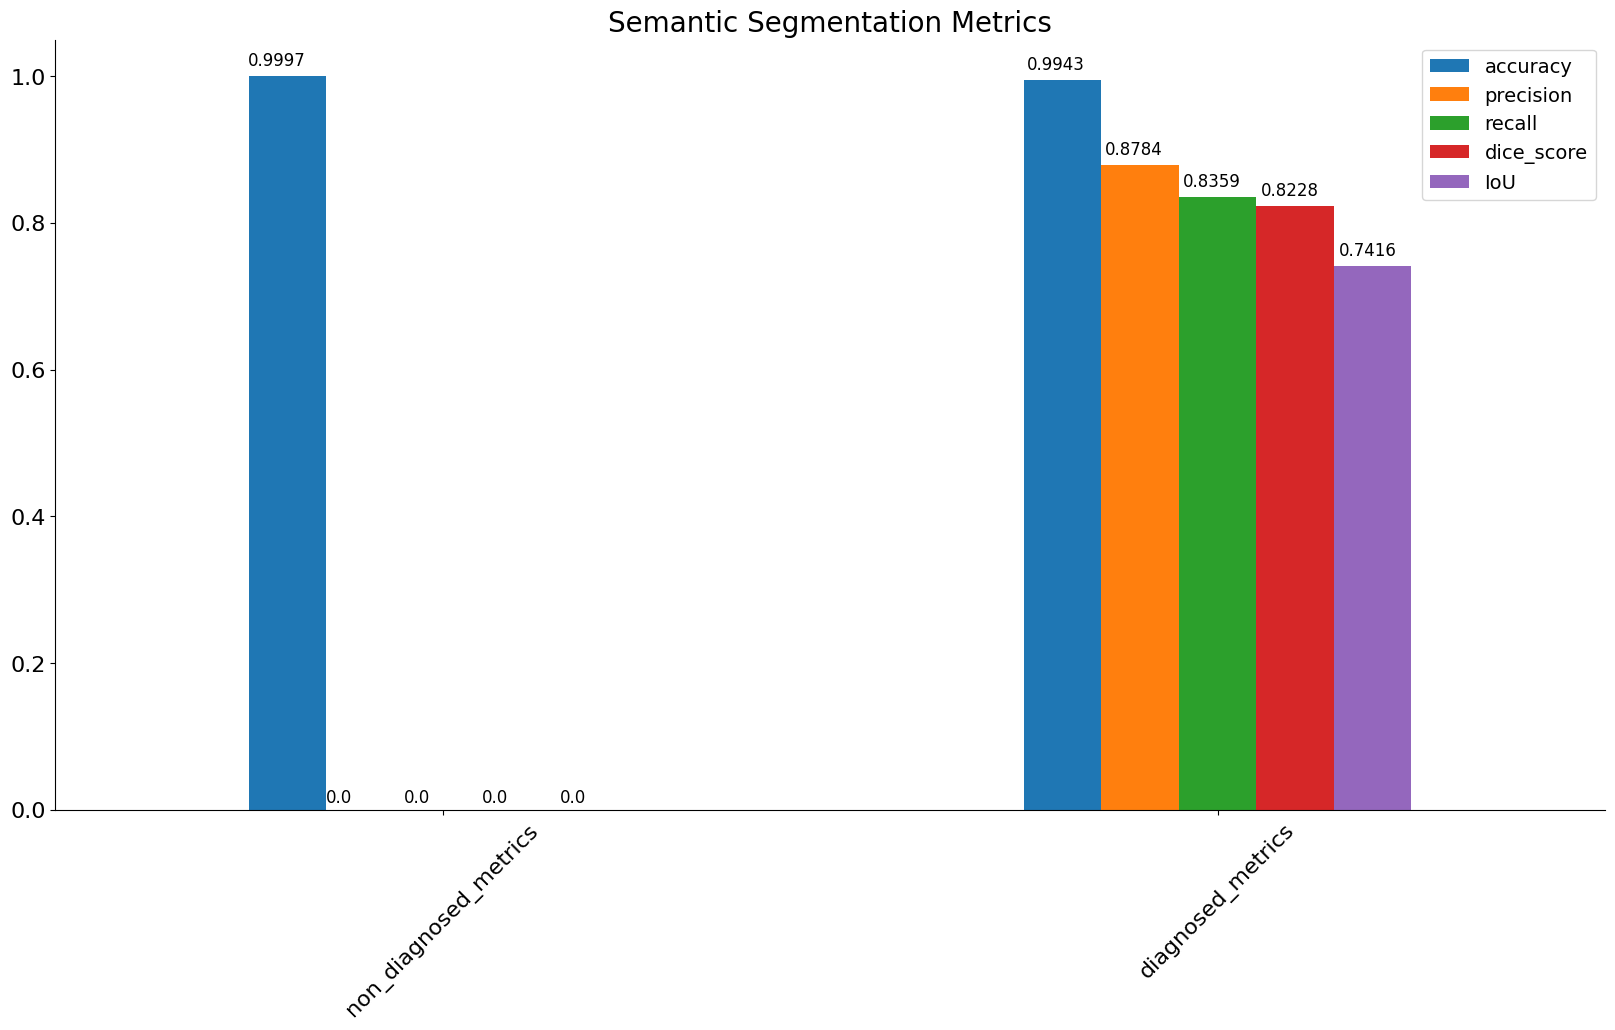

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your plot code
ax = segmentation_metrics.plot(
    kind="bar", rot=0,
    figsize=(20, 10)
)

ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=14)

for p in ax.patches:
    bar_value = p.get_height()
    text = '0.0' if bar_value==0 else f'{bar_value:.4f}'
    ax.annotate(
        text,
        (p.get_x() * 1.005, p.get_height() * 1.005 + 0.01),
        fontsize=12
    )

ax.tick_params( axis='both', which='major',
    labelsize=16
)

ax.tick_params(
    axis='x', which='major',
    labelsize=16, rotation=45
)

plt.title('Semantic Segmentation Metrics', fontsize=20)
sns.despine()

# Saving the image
plt.savefig('/content/drive/MyDrive/Medical Image Segmentation/segmentation_metrics.png', bbox_inches='tight')

In [30]:
labels = unet_test_df['diagnosis'].to_numpy()
predictions = unet_test_df['model_diagnosis'].to_numpy()

In [31]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions, target_names=['NORMAL', 'TUMOR']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.95      0.96       425
       TUMOR       0.88      0.95      0.91       165

    accuracy                           0.95       590
   macro avg       0.93      0.95      0.94       590
weighted avg       0.95      0.95      0.95       590



In [36]:
import random
def view_multiple_predictions(
    model, ds, count=10,
    color_map='rgb',
    fig_size=(14, 10),
    title_size=16):

    # Select random samples
    idx = random.sample(list(range(len(ds))), count)

    # Initialise figure
    fig = plt.figure(figsize=fig_size)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Plot Samples
    for row, _ in enumerate(idx):
        image, mask = ds[_]
        idx = 3 * (row + 1)

        # Plot MRI Image
        plt.subplot(count+1, 3, idx + 1)
        plt.title(f'MRI Image', fontsize=title_size)
        if color_map=='rgb':
            plt.imshow(image.permute(1, 2, 0))
        else:
            plt.imshow(image.permute(1, 2, 0), cmap=color_map)

        # Plot Mask
        plt.subplot(count+1, 3, idx + 2)
        plt.title(f'True Mask', fontsize=title_size)

        gen_mask = np.dstack([mask[0]*0.1, mask[0]*0.45, mask[0]*0.1])
        plt.imshow(image.permute(1, 2, 0) + gen_mask)

        # Generate predicted mask
        mri_input = torch.unsqueeze(torch.tensor(image), dim=0)

        with torch.inference_mode():
            pred_mask = model(mri_input)
            pred_mask = torch.sigmoid(pred_mask).cpu()
            pred_mask = (pred_mask > 0.5) #threshold of 0.5

        # Plot Predicted Mask
        plt.subplot(count+1, 3, idx + 3)
        plt.title(f'Predicted Mask', fontsize=title_size)

        #This line creates a colored mask visualization by stacking the binary mask pred_mask along the depth dimension using np.dstack.
        pred_gen_mask = np.dstack([pred_mask[0][0]*0.3, pred_mask[0][0]*0.2, pred_mask[0][0]*0.8])
        plt.imshow(image.permute(1, 2, 0)+ pred_gen_mask)

    return

In [37]:
# Create Dataset for Diagnosed Sample
test_diagnosed_ds = MRISegmentationDataset(unet_test_df[unet_test_df['diagnosis'] == 1].reset_index(drop=True), transform=inference_transforms)

<ipython-input-36-76e872da10cc>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mri_input = torch.unsqueeze(torch.tensor(image), dim=0)


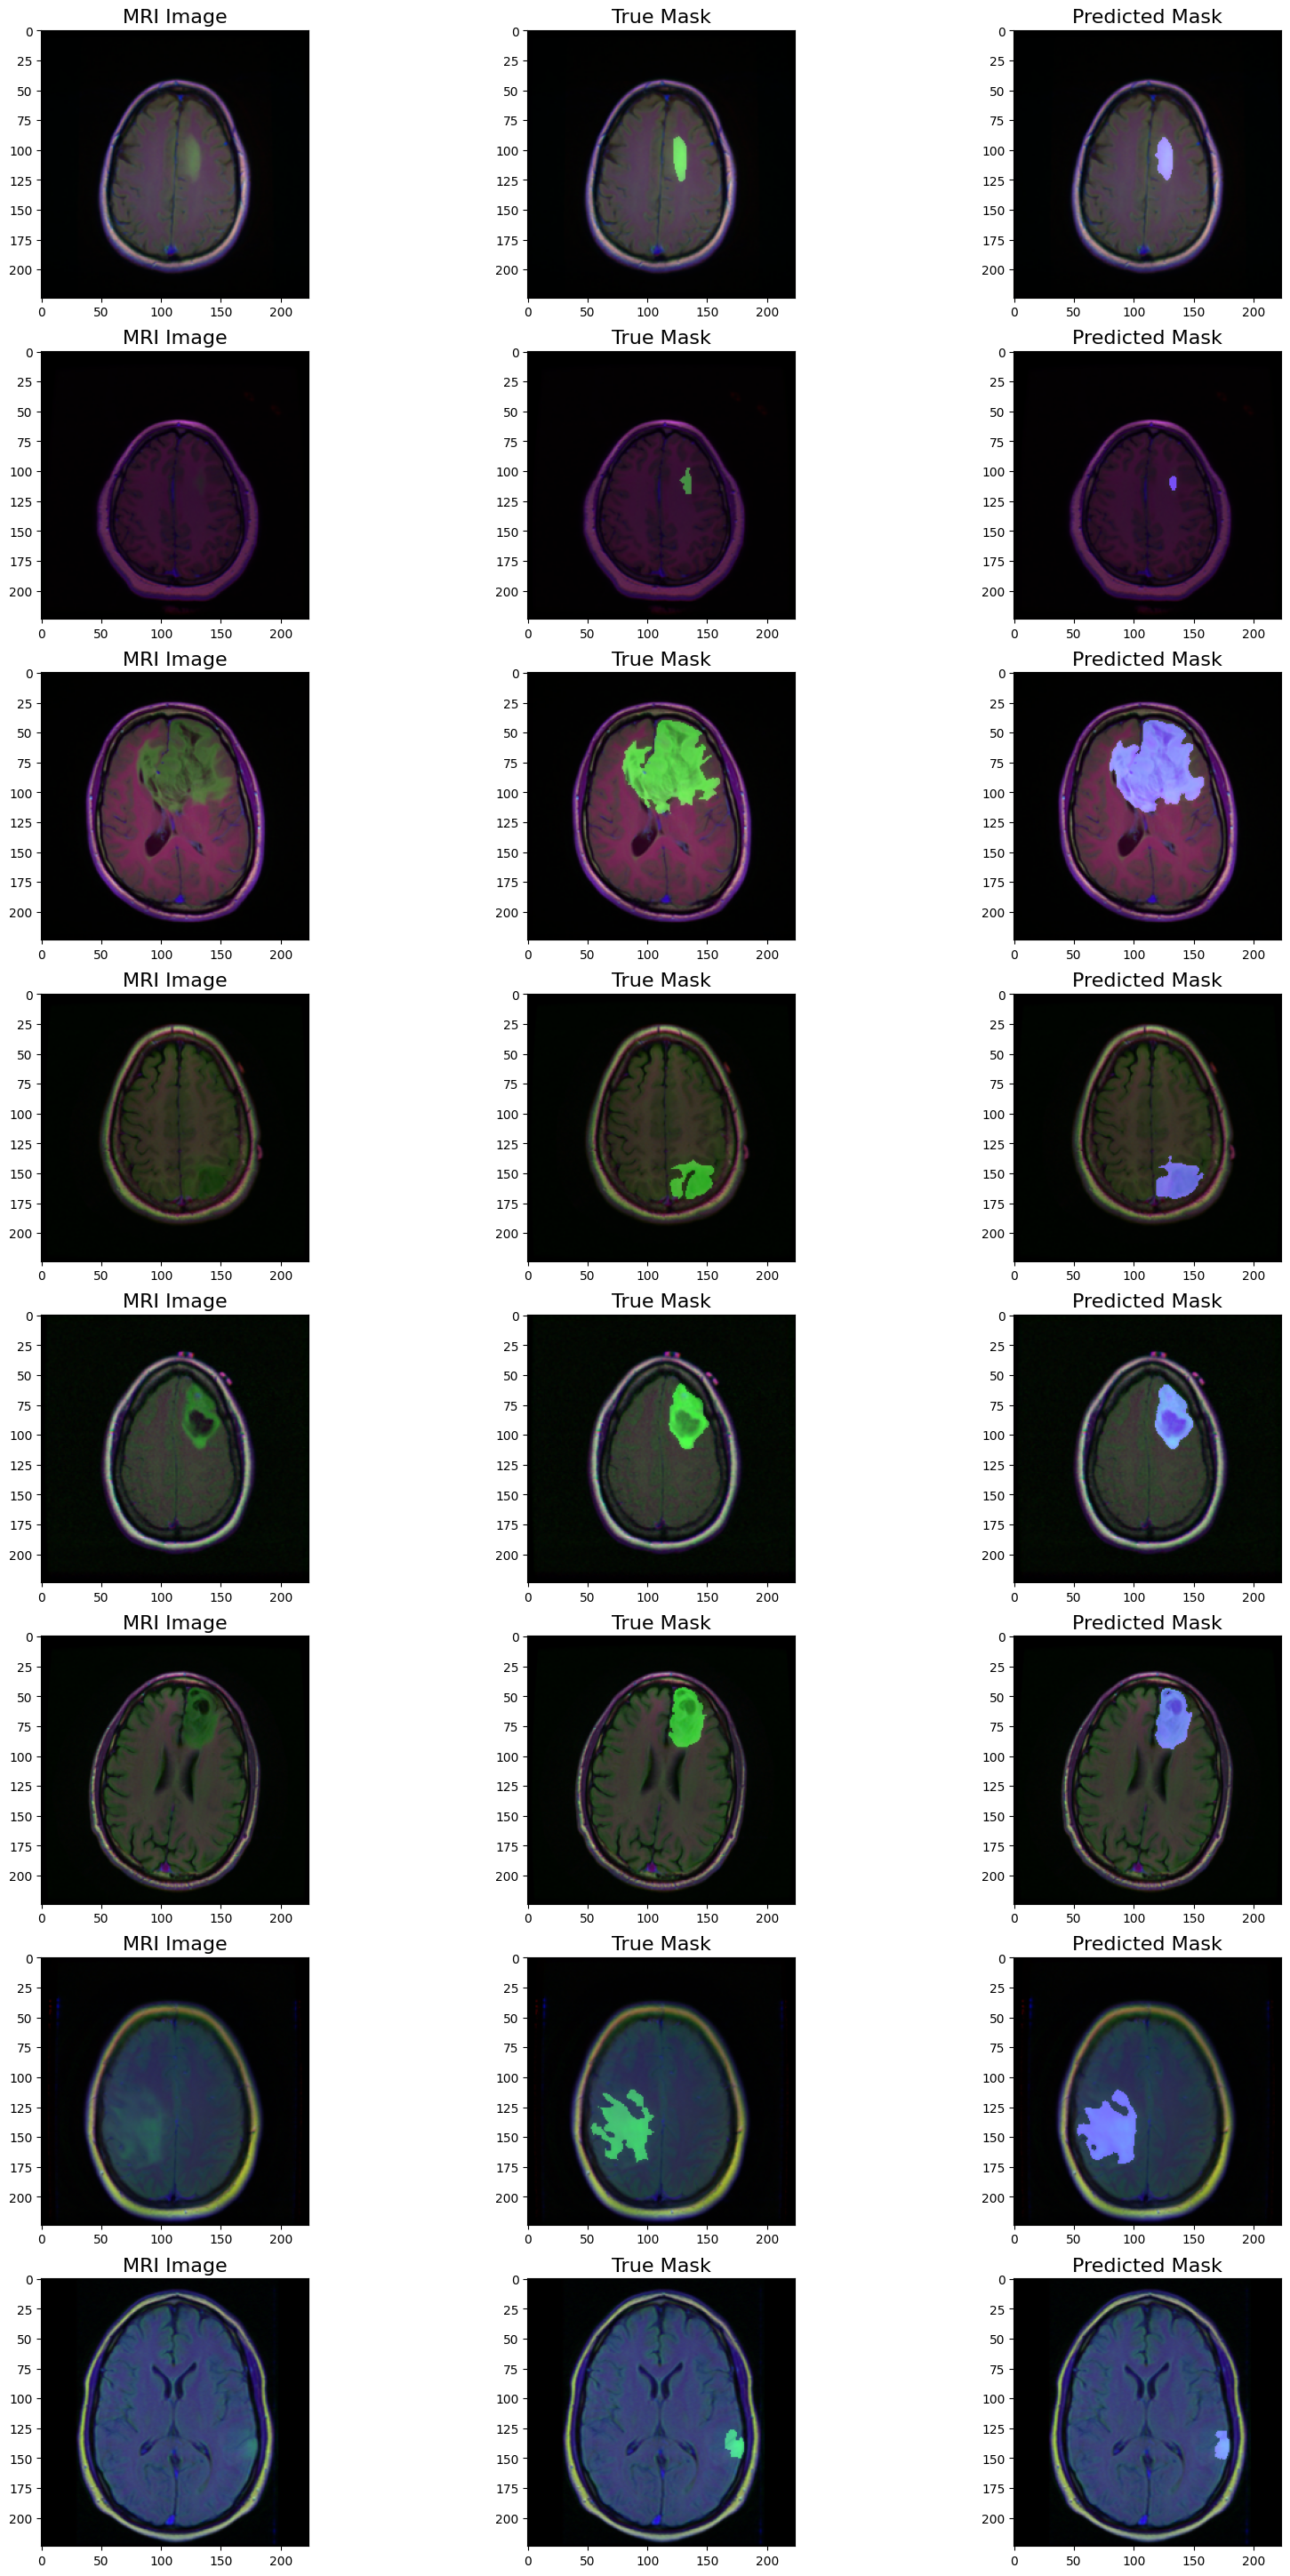

In [39]:
# View Random Samples
view_multiple_predictions(model.to('cpu'), test_diagnosed_ds, count=8, color_map='rgb',fig_size=(20, 38))